### Persistence images from distance matrix

In [2]:
# import libraries
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import traceback
import pandas as pd


from ripser import Rips
from persim import PersistenceImager

import glob
import pickle
import geopandas as gpd
import dcor
import pandas as pd

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import ripser
import persim

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

In [11]:
# Define constant variables
DATA_DIR = "/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/selected coordinates for each state - percentiles(below 90th)- all variables"
RESULTS_DIR = "/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/persistence images/below 90th percentile/h1h0/distance matrix 16 channels npy"
VARIABLES = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']
PERSISTENCE_IMAGE_SHAPE = (310, 310)
NUMBER_OF_VARIABLES = 16
PERSISTENCE_IMAGE_PARAMS = {
    'pixel_size': 0.001,
    'birth_range': (0.0, 0.9),
    'pers_range': (0.0, 0.9),
    'kernel_params': {'sigma': 0.00004}
}

In [6]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/svi with hepvu/2018/SVI 2018 with HepVu census tracts/SVI2018_US_census_with_opioid_indicators.shp')

In [7]:
# Function to get the list of folders in a specified location
def get_folders(location):
    return [name for name in os.listdir(location) if os.path.isdir(os.path.join(location, name))]

# Get the list of state folders
states = get_folders(DATA_DIR)

#### Get the range of data

In [8]:
# let's identify max H0 and H1 values

max_h0 = 0

max_h1_birth = 0
max_h1_persistence = 0

# Loop through each state
for state in tqdm(states, desc="Processing states"):
    print('Processing:', state)

    try:
        # Load data from pickle files into a dictionary
        data = {}

        for file in glob.glob(os.path.join(DATA_DIR, state, '*.pkl')):
            with open(file, 'rb') as f:
                
                # Extract the last 20 characters of the file name
                extracted_words = file[-20:]

                # Search for numbers in the extracted string
                match = re.search(r'(\d+)', extracted_words)
                if match:
                    extracted_number = match.group(1)
                    # Load the pickle file data into the dictionary
                    data[extracted_number] = pd.read_pickle(f)
                else:
                    print("No number found in the string.")

                 # Process each county (FIPS) in the data
        for fips, dictionary in data.items():
            # Dictionary where the key is the county code (FIPS) and the value is another dictionary
            # print('Processing:', fips)

            for key, value in dictionary.items():

                # If the value is not empty, process it
                if len(value) > 0:
                    distance_matrix = np.zeros((NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES))

                    # get the selected fips realated to the specific variable
                    selected_fips = value['FIPS'].tolist()
     
                    # filter the dataframe svi_df to only include the selected fips
                    svi_df_selected_fips = us_svi[us_svi['FIPS'].isin(selected_fips)]
                    svi_df_selected_fips = svi_df_selected_fips[VARIABLES]

                    # create a matrix
                    data_matrix = svi_df_selected_fips.to_numpy()

                    # compute the distance matrix
                    for i in range(NUMBER_OF_VARIABLES):
                        for j in range(NUMBER_OF_VARIABLES):
                            distance_matrix[i, j] = dcor.distance_correlation(data_matrix[:, i], data_matrix[:, j]) #Distance Correlations 

                    distance_matrix = distance_matrix.T + np.eye(NUMBER_OF_VARIABLES)
                    distance_matrix = 1 - distance_matrix

                    # Create persistence diagram using Rips class
                    rips = Rips(maxdim=1, coeff=2)
                    dgms = ripser.ripser(distance_matrix, distance_matrix=True)['dgms']

                    # Separate the diagrams for H0 and H1
                    diagrams_h0 = dgms[0]
                    diagrams_h1 = dgms[1]

                    # If H0 diagram is not empty, process it
                    if len(diagrams_h0) > 1: 
                        # Remove last data point in H0 diagram (it is infinity)
                        diagrams_h0_without_inf = diagrams_h0[0:-1]

                        temp_max_h0 = np.max(diagrams_h0_without_inf)
                        if temp_max_h0 > max_h0:
                            max_h0 = temp_max_h0

                    # If H1 diagram is not empty, process it
                    if len(diagrams_h1) > 0:
                        temp_max_h1_birth = np.max(diagrams_h1[:, 0])
                        temp_max_h1_persistence = np.max(diagrams_h1[:, 1])

                        if temp_max_h1_birth > max_h1_birth:
                            max_h1_birth = temp_max_h1_birth
                        
                        if temp_max_h1_persistence > max_h1_persistence:
                            max_h1_persistence = temp_max_h1_persistence


    except Exception as e:
        print(f"Error processing {state}: {e}")
        traceback.print_exc()
        continue  # Continue to the next iteration if an error occurs

print('All states processed.')

Processing states:   0%|          | 0/50 [00:00<?, ?it/s]

Processing: VT
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:   2%|▏         | 1/50 [00:02<02:03,  2.52s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: VA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:   4%|▍         | 2/50 [00:31<14:33, 18.20s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: SD
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:   6%|▌         | 3/50 [00:45<12:37, 16.11s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: SC
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:   8%|▊         | 4/50 [00:55<10:40, 13.92s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  10%|█         | 5/50 [01:02<08:30, 11.34s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: GA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  12%|█▏        | 6/50 [01:34<13:20, 18.20s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: MS
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  14%|█▍        | 7/50 [01:48<12:01, 16.78s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: MT
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  16%|█▌        | 8/50 [01:57<10:10, 14.53s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: MO
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  18%|█▊        | 9/50 [02:18<11:16, 16.50s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: MA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  20%|██        | 10/50 [02:23<08:37, 12.94s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: AK
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  22%|██▏       | 11/50 [02:27<06:38, 10.21s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: KY
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  24%|██▍       | 12/50 [02:48<08:27, 13.37s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  26%|██▌       | 13/50 [03:00<07:59, 12.95s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  28%|██▊       | 14/50 [03:02<05:46,  9.61s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: MN
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  30%|███       | 15/50 [03:17<06:38, 11.39s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  32%|███▏      | 16/50 [03:34<07:28, 13.19s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: OK
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  34%|███▍      | 17/50 [03:48<07:22, 13.41s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  36%|███▌      | 18/50 [04:08<08:09, 15.30s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: CO
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  38%|███▊      | 19/50 [04:21<07:35, 14.68s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: CA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  40%|████      | 20/50 [04:56<10:24, 20.82s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: IA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  42%|████▏     | 21/50 [05:15<09:42, 20.08s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  44%|████▍     | 22/50 [05:17<06:56, 14.87s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: FL
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  46%|████▌     | 23/50 [05:35<07:06, 15.79s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: WV
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  48%|████▊     | 24/50 [05:44<05:58, 13.77s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: RI
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  50%|█████     | 25/50 [05:46<04:09,  9.98s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  52%|█████▏    | 26/50 [05:50<03:18,  8.25s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  54%|█████▍    | 27/50 [06:42<08:10, 21.31s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  56%|█████▌    | 28/50 [06:57<07:08, 19.50s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: NC
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  58%|█████▊    | 29/50 [07:15<06:37, 18.94s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: ND
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  60%|██████    | 30/50 [07:23<05:15, 15.79s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: NM
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  62%|██████▏   | 31/50 [07:28<04:01, 12.70s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: NJ
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  64%|██████▍   | 32/50 [07:35<03:15, 10.87s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: ME
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  66%|██████▌   | 33/50 [07:38<02:22,  8.40s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  68%|██████▊   | 34/50 [07:50<02:34,  9.66s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: NV
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  70%|███████   | 35/50 [07:54<01:59,  7.96s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  72%|███████▏  | 36/50 [08:00<01:41,  7.28s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: KS
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  74%|███████▍  | 37/50 [08:17<02:14, 10.35s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: NE
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  76%|███████▌  | 38/50 [08:33<02:23, 11.92s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  78%|███████▊  | 39/50 [08:34<01:36,  8.74s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: DE
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  80%|████████  | 40/50 [08:35<01:03,  6.33s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  82%|████████▏ | 41/50 [08:41<00:55,  6.12s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: NY
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  84%|████████▍ | 42/50 [09:00<01:20, 10.01s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  86%|████████▌ | 43/50 [09:07<01:04,  9.20s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  88%|████████▊ | 44/50 [09:24<01:09, 11.63s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  90%|█████████ | 45/50 [09:31<00:50, 10.10s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  92%|█████████▏| 46/50 [09:52<00:53, 13.47s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: LA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  94%|█████████▍| 47/50 [10:04<00:38, 12.84s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

Processing states:  96%|█████████▌| 48/50 [10:16<00:25, 12.71s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: WA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  98%|█████████▊| 49/50 [10:24<00:11, 11.38s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: TN
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states: 100%|██████████| 50/50 [10:41<00:00, 12.82s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
All states processed.


In [9]:
print("Max H0 value: ", max_h0)
print("Max H1 birth value: ", max_h1_birth)
print("Max H1 persistence value: ", max_h1_persistence)

Max H0 value:  inf
Max H1 birth value:  0.8710317611694336
Max H1 persistence value:  inf


In [13]:
# Create a folder for each variable if it does not exist
for variable in VARIABLES:
    os.makedirs(os.path.join(RESULTS_DIR, variable), exist_ok=True)
print('Done creating folders for each variable')

Done creating folders for each variable


Processing states:   0%|          | 0/50 [00:00<?, ?it/s]

Processing: VT
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:   2%|▏         | 1/50 [00:23<19:05, 23.38s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing VT: cannot convert float infinity to integer
Processing: VA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:   4%|▍         | 2/50 [00:55<23:00, 28.75s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing VA: cannot convert float infinity to integer
Processing: SD
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:   6%|▌         | 3/50 [01:00<13:59, 17.87s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing SD: cannot convert float infinity to integer
Processing: SC
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:   8%|▊         | 4/50 [02:01<26:45, 34.89s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing SC: cannot convert float infinity to integer
Processing: UT
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  10%|█         | 5/50 [02:20<21:43, 28.96s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing UT: cannot convert float infinity to integer
Processing: GA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  12%|█▏        | 6/50 [02:25<15:17, 20.86s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing GA: cannot convert float infinity to integer
Processing: MS
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  14%|█▍        | 7/50 [02:33<11:51, 16.55s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing MS: cannot convert float infinity to integer
Processing: MT
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  16%|█▌        | 8/50 [02:41<09:52, 14.10s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing MT: cannot convert float infinity to integer
Processing: MO
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  18%|█▊        | 9/50 [02:45<07:19, 10.71s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing MO: cannot convert float infinity to integer
Processing: MA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Processing states:  20%|██        | 10/50 [03:18<11:50, 17.75s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: AK
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  22%|██▏       | 11/50 [03:20<08:26, 12.99s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing AK: cannot convert float infinity to integer
Processing: KY


Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  24%|██▍       | 12/50 [03:21<05:49,  9.21s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing KY: cannot convert float infinity to integer
Processing: AL
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  26%|██▌       | 13/50 [03:33<06:09,  9.99s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing AL: cannot convert float infinity to integer
Processing: NH
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Processing states:  28%|██▊       | 14/50 [03:56<08:21, 13.93s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: MN
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  30%|███       | 15/50 [04:04<07:11, 12.32s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing MN: cannot convert float infinity to integer
Processing: MI
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  32%|███▏      | 16/50 [04:11<06:00, 10.61s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing MI: cannot convert float infinity to integer
Processing: OK
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  34%|███▍      | 17/50 [04:13<04:22,  7.94s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing OK: cannot convert float infinity to integer
Processing: IN
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
ValueError: cannot convert float NaN to integer
Processing states:  36%|███▌      | 18/50 [04:19<03:55,  7.37s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing IN: cannot convert float NaN to integer
Processing: CO
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  38%|███▊      | 19/50 [04:22<03:07,  6.05s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing CO: cannot convert float infinity to integer
Processing: CA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  40%|████      | 20/50 [04:33<03:47,  7.58s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing CA: cannot convert float infinity to integer
Processing: IA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  42%|████▏     | 21/50 [05:17<08:58, 18.58s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing IA: cannot convert float infinity to integer
Processing: CT
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Processing states:  44%|████▍     | 22/50 [05:36<08:42, 18.67s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: FL
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  46%|████▌     | 23/50 [05:55<08:23, 18.65s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing FL: cannot convert float infinity to integer
Processing: WV
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  48%|████▊     | 24/50 [05:59<06:12, 14.32s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing WV: cannot convert float infinity to integer
Processing: RI
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Processing states:  50%|█████     | 25/50 [06:10<05:34, 13.37s/it]

Processing: WY
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  52%|█████▏    | 26/50 [06:10<03:47,  9.47s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing WY: cannot convert float infinity to integer
Processing: TX
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  54%|█████▍    | 27/50 [06:26<04:20, 11.31s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing TX: cannot convert float infinity to integer
Processing: PA
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  56%|█████▌    | 28/50 [07:00<06:39, 18.18s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing PA: cannot convert float infinity to integer
Processing: NC
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  58%|█████▊    | 29/50 [07:06<05:07, 14.62s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing NC: cannot convert float infinity to integer
Processing: ND
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  60%|██████    | 30/50 [07:15<04:18, 12.94s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing ND: cannot convert float infinity to integer
Processing: NM
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  62%|██████▏   | 31/50 [07:24<03:41, 11.68s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing NM: cannot convert float infinity to integer
Processing: NJ
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)

Processing states:  64%|██████▍   | 32/50 [08:18<07:19, 24.39s/it]

Processing: ME
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  66%|██████▌   | 33/50 [09:01<08:28, 29.94s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Processing: AR
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^^^^^^^^^^^^^^
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 464, in pers_range
    int(np.ceil((self.pers_range[1] - self.pers_range[0]) / self.pixel_size))
OverflowError: cannot convert float infinity to integer
Processing states:  68%|██████▊   | 34/50 [09:07<06:04, 22.76s/it]Traceback (most recent call last):
  File "/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_44848/1199842349.py", line 67, in <module>
    pimgr_0.fit(diagrams_h0_without_inf)
  File "/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/persim/images.py", line 652, in fit
    self.pers_range = (min_pers, max_pers)
    ^^

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing AR: cannot convert float infinity to integer
Processing: NV
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Error processing NV: cannot convert float infinity to integer
Processing: MD
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(m

Processing states:  72%|███████▏  | 36/50 [10:08<06:50, 29.31s/it]

Processing: KS
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm

Processing states:  72%|███████▏  | 36/50 [10:23<04:02, 17.33s/it]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


KeyboardInterrupt: 

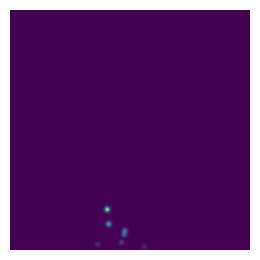

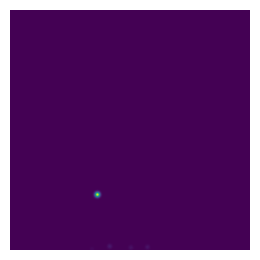

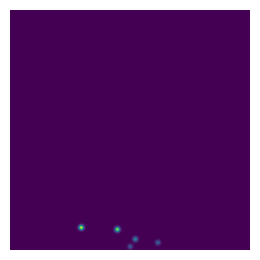

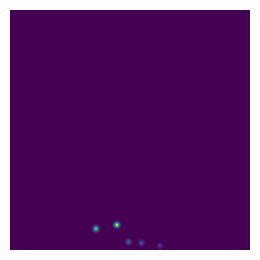

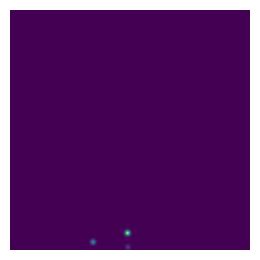

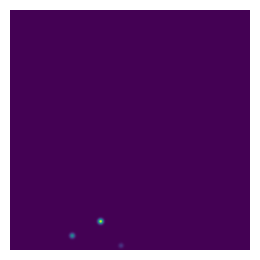

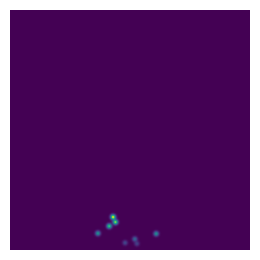

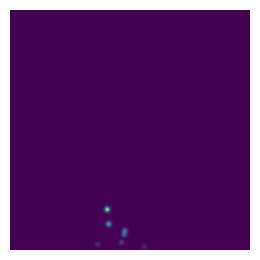

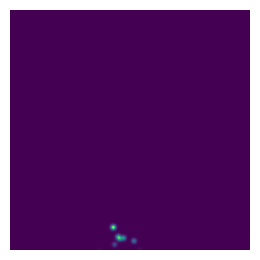

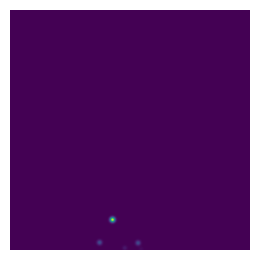

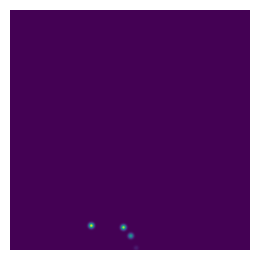

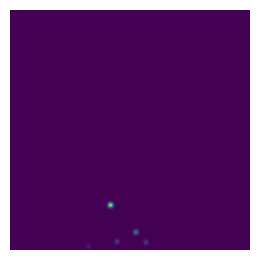

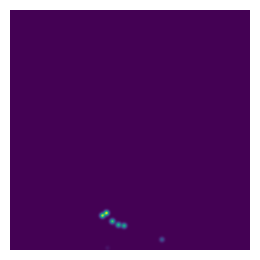

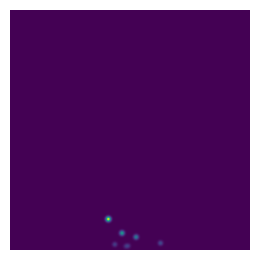

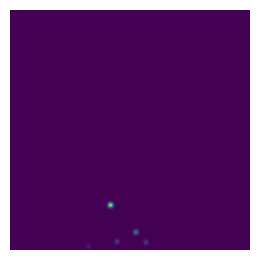

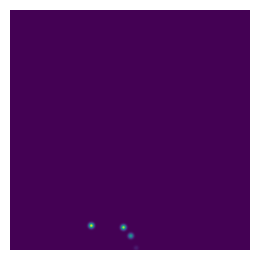

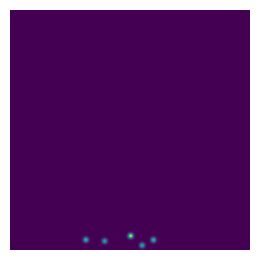

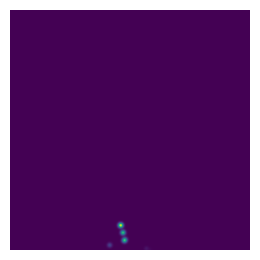

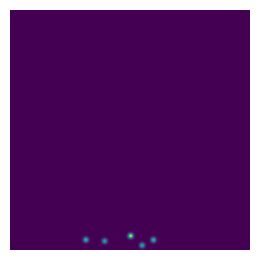

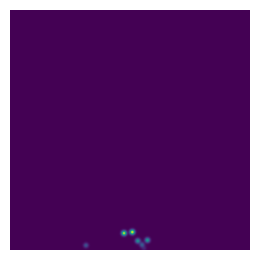

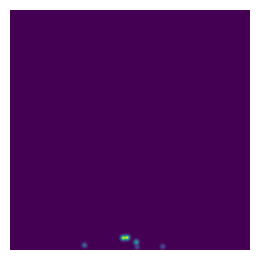

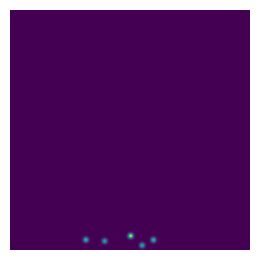

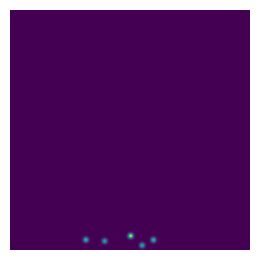

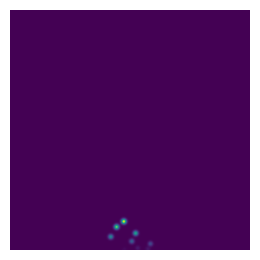

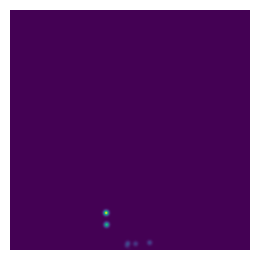

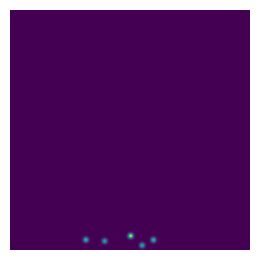

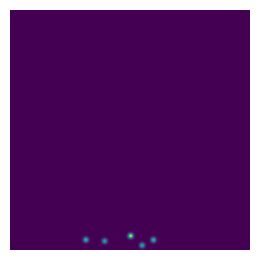

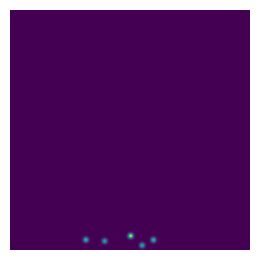

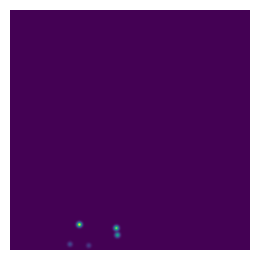

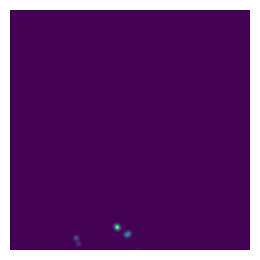

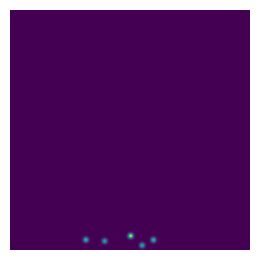

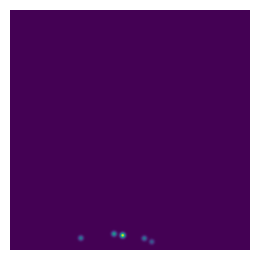

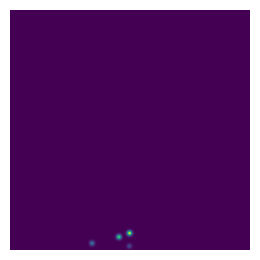

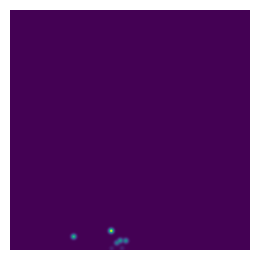

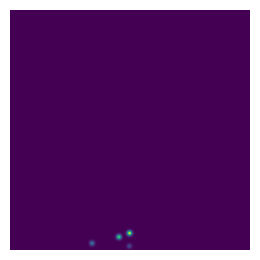

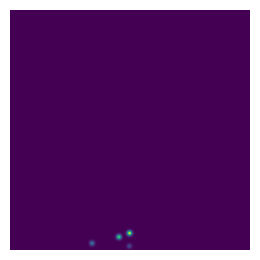

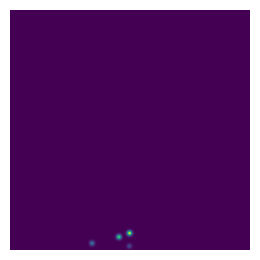

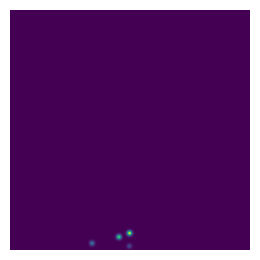

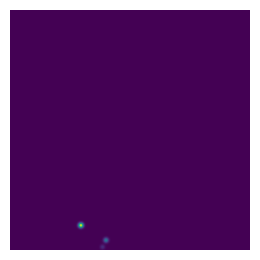

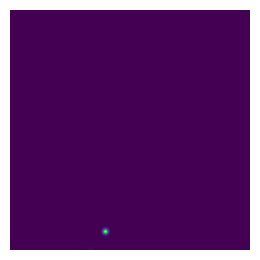

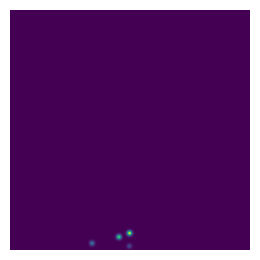

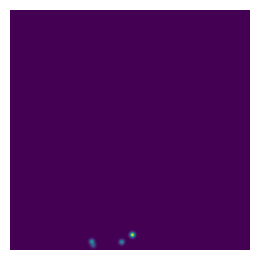

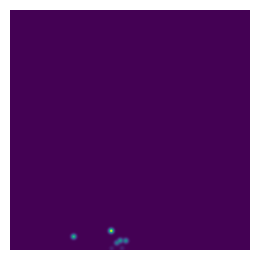

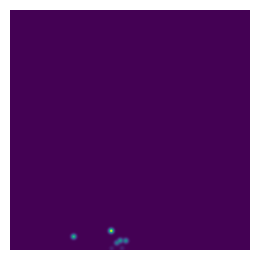

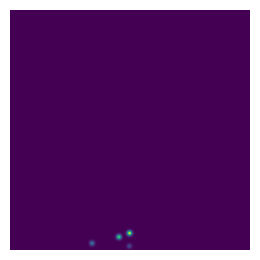

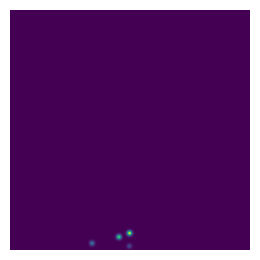

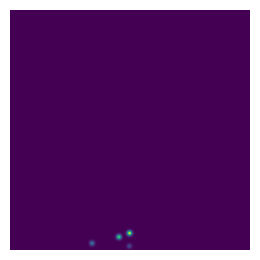

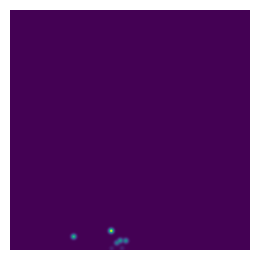

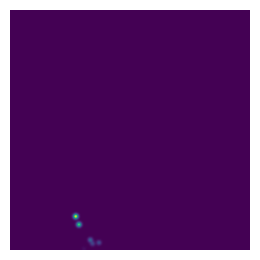

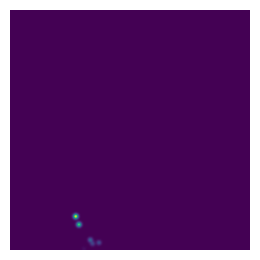

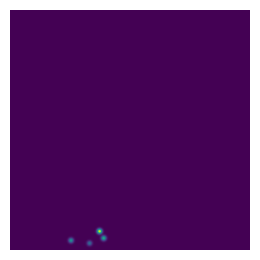

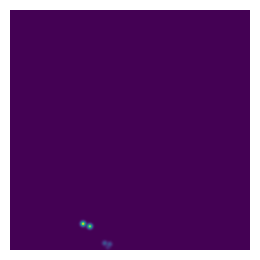

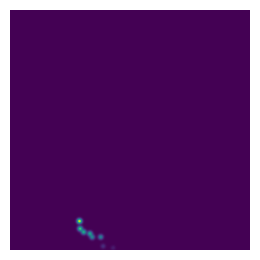

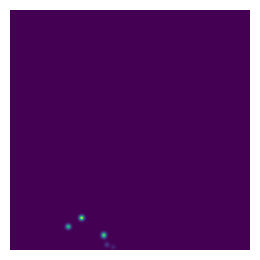

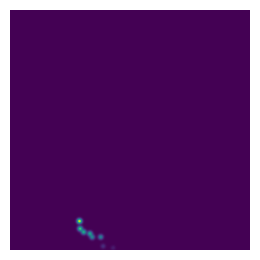

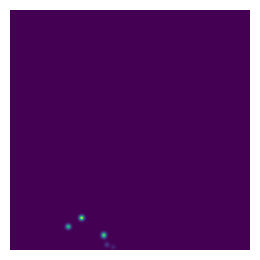

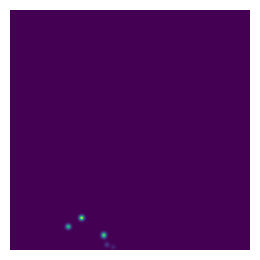

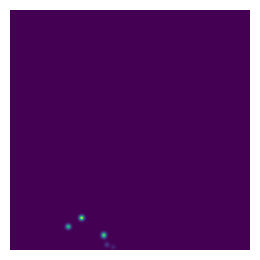

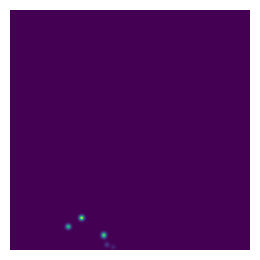

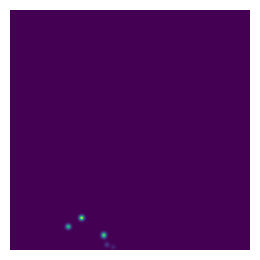

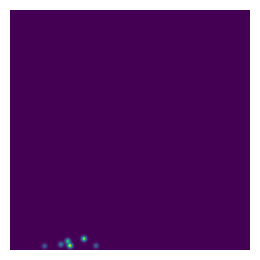

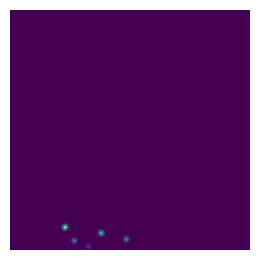

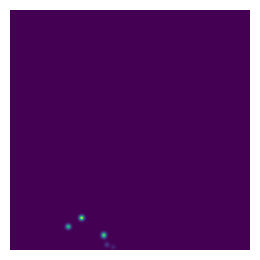

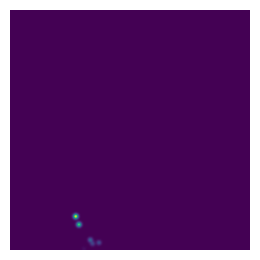

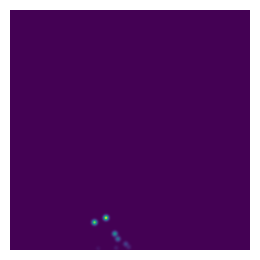

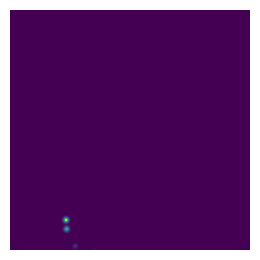

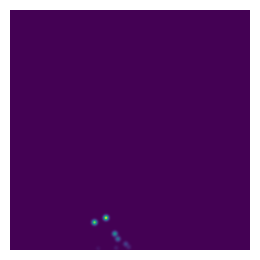

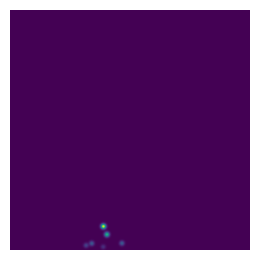

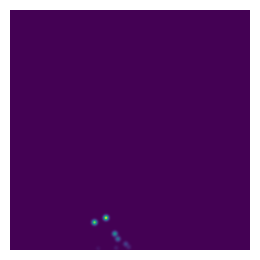

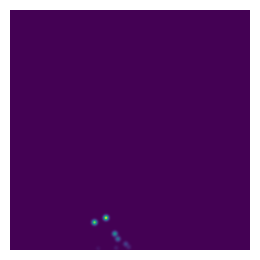

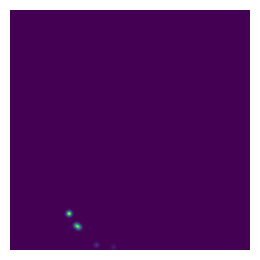

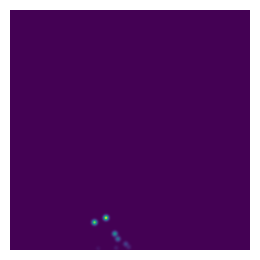

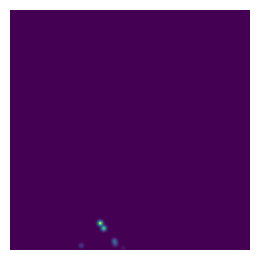

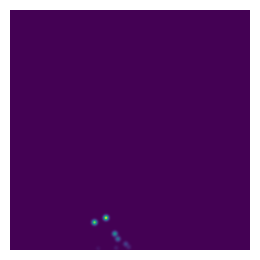

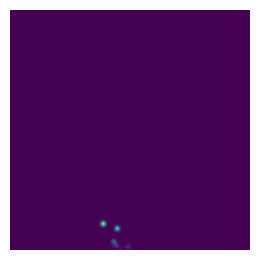

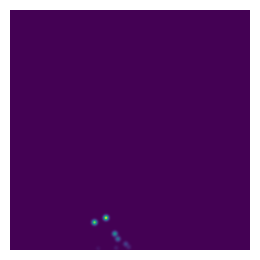

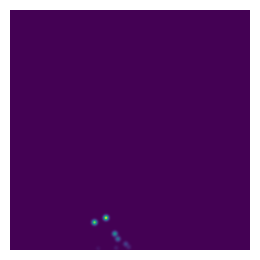

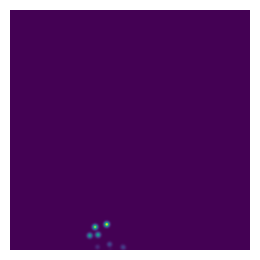

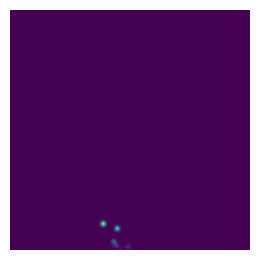

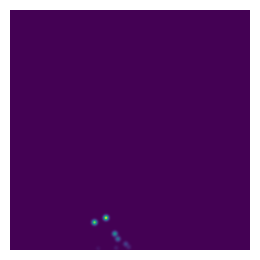

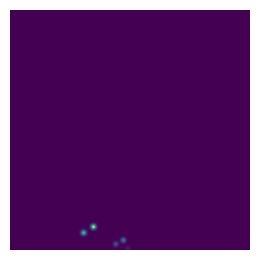

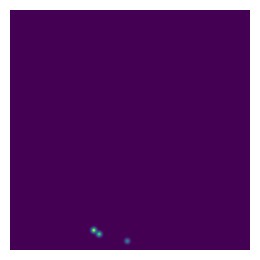

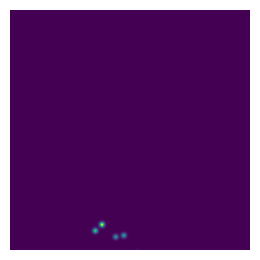

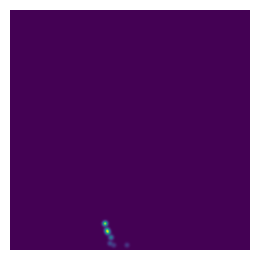

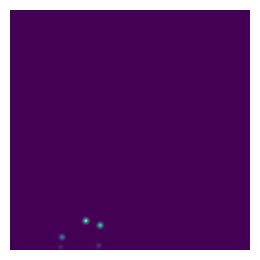

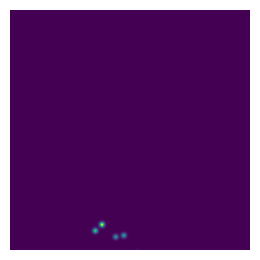

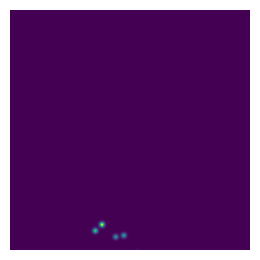

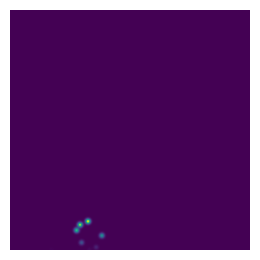

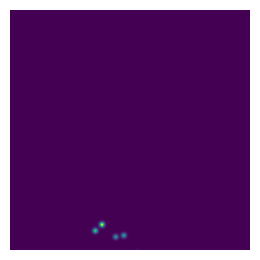

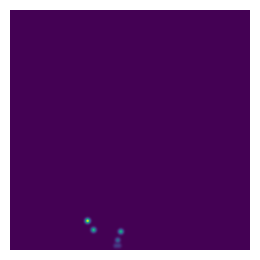

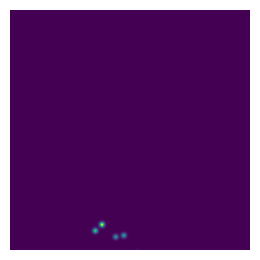

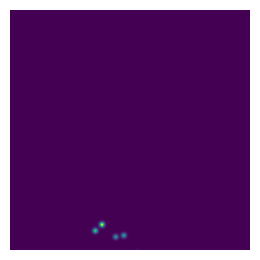

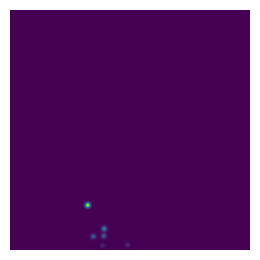

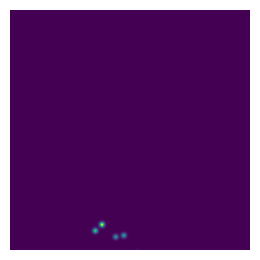

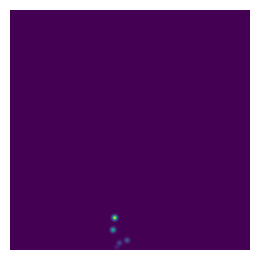

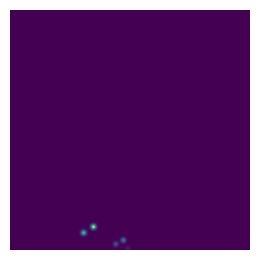

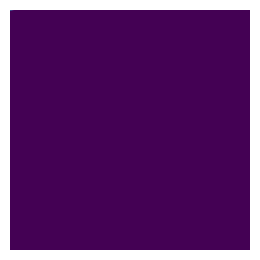

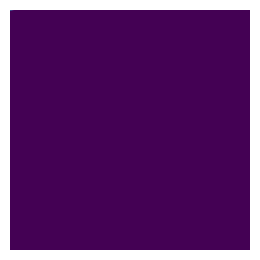

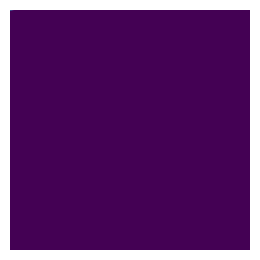

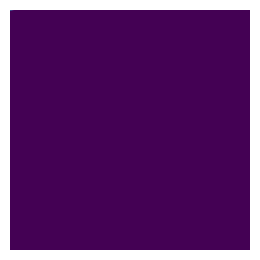

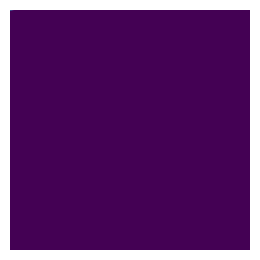

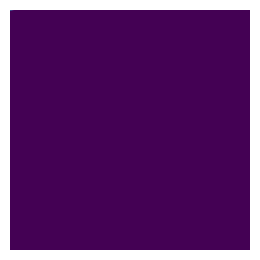

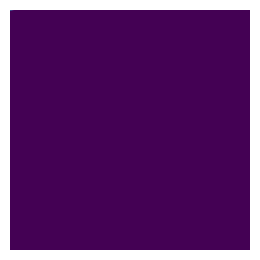

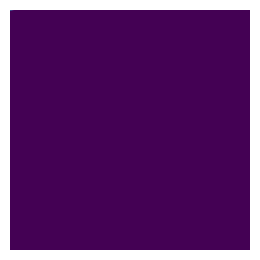

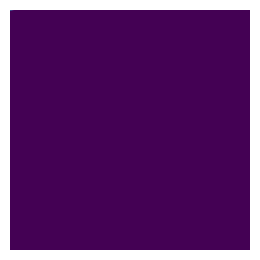

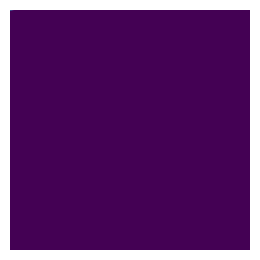

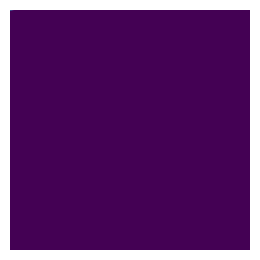

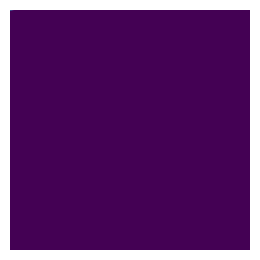

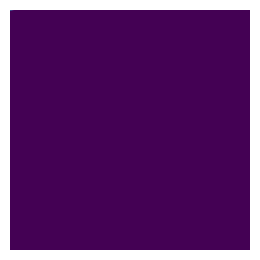

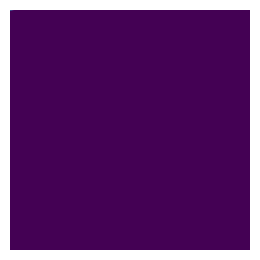

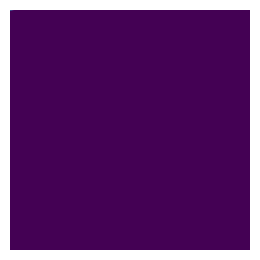

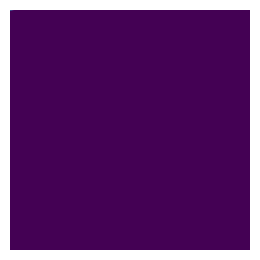

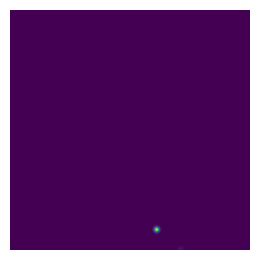

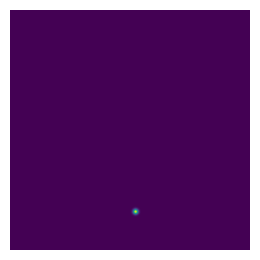

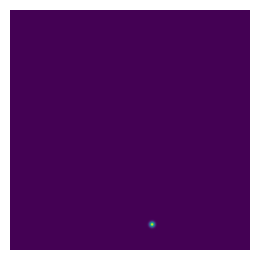

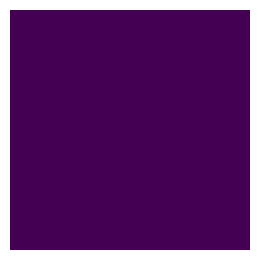

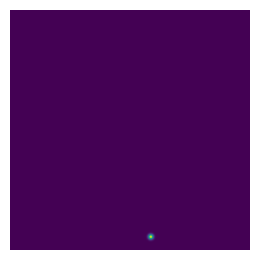

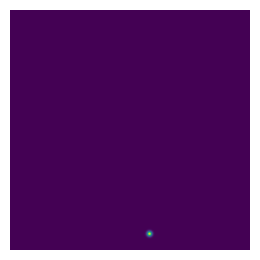

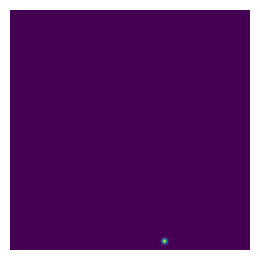

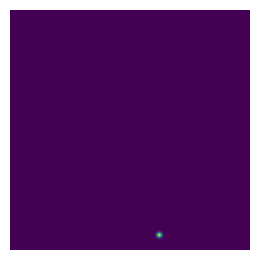

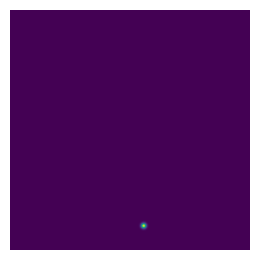

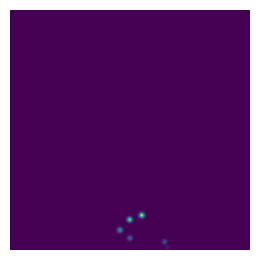

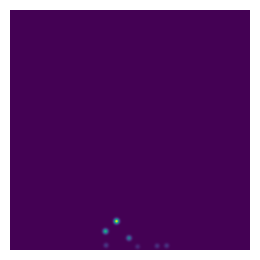

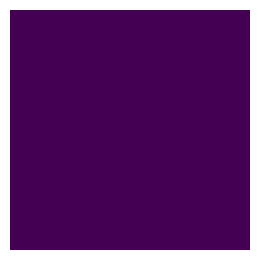

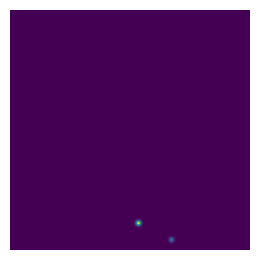

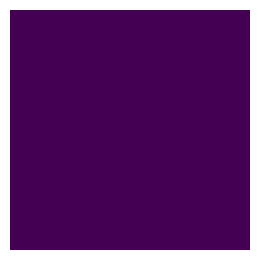

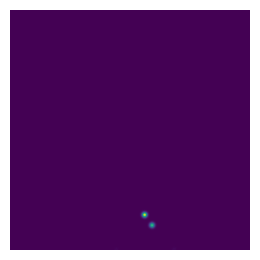

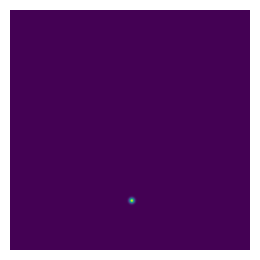

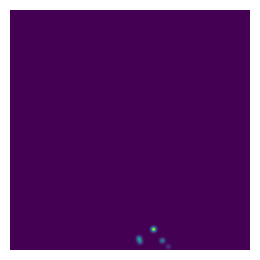

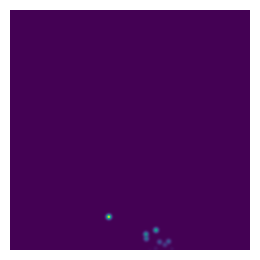

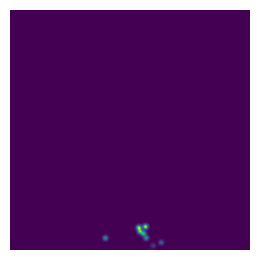

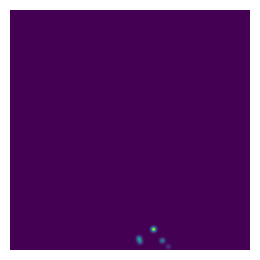

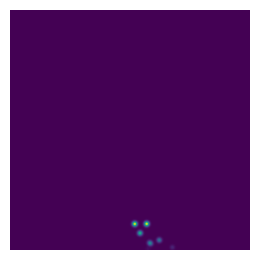

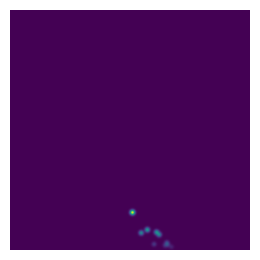

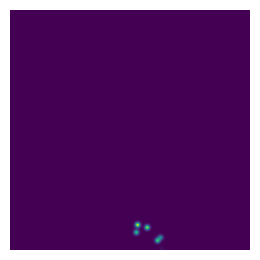

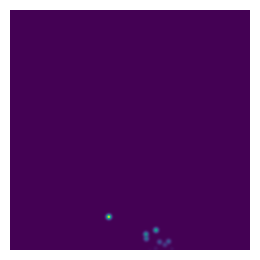

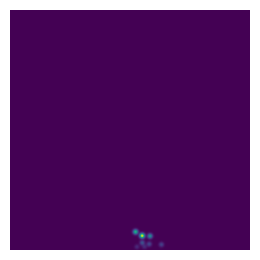

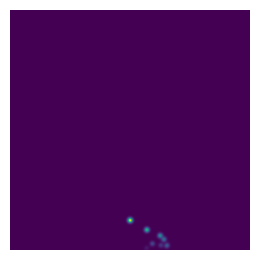

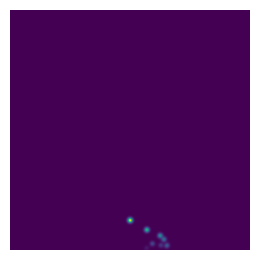

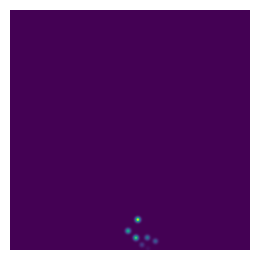

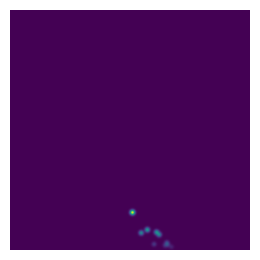

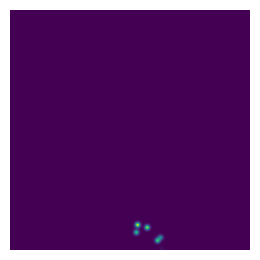

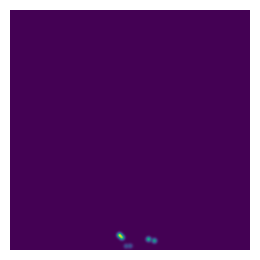

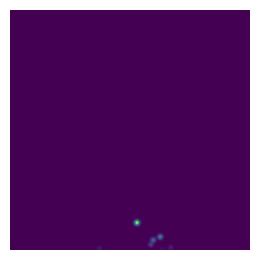

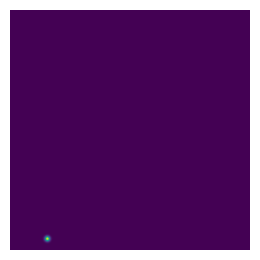

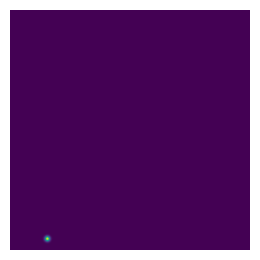

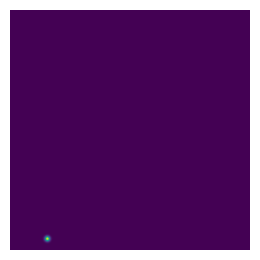

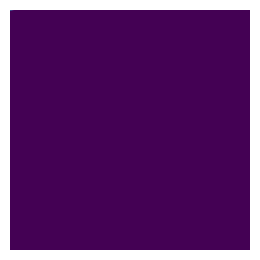

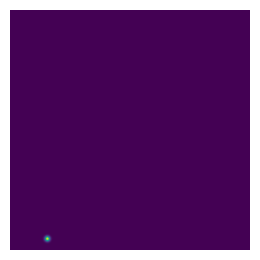

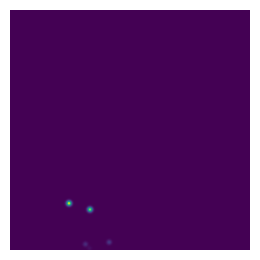

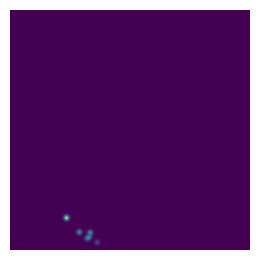

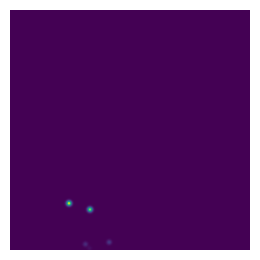

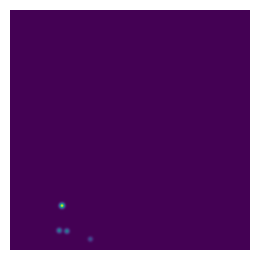

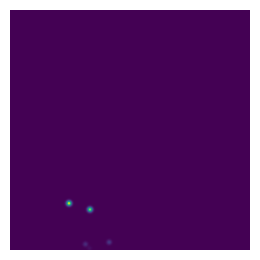

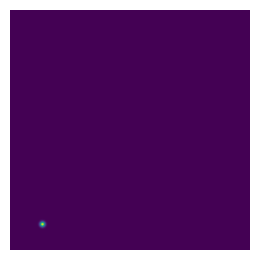

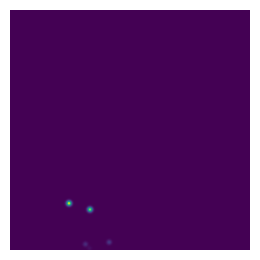

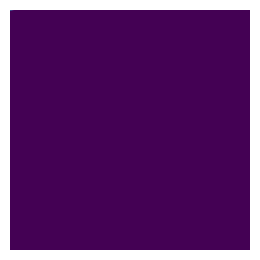

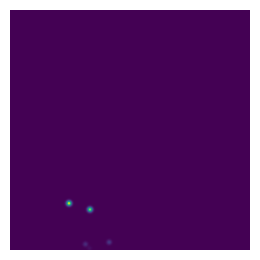

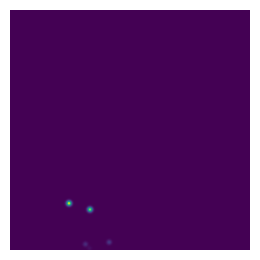

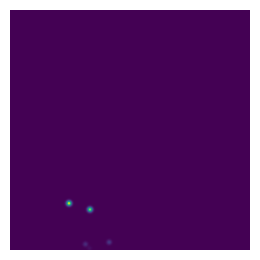

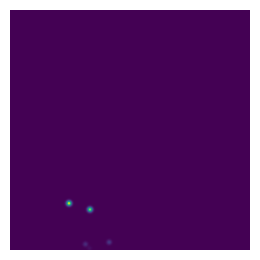

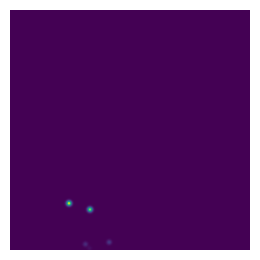

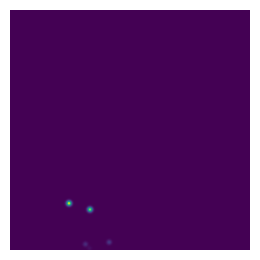

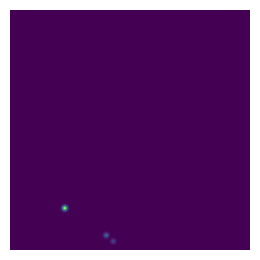

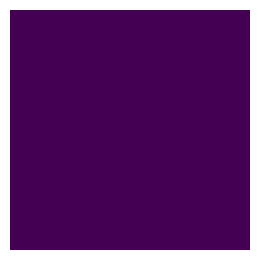

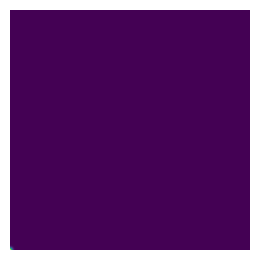

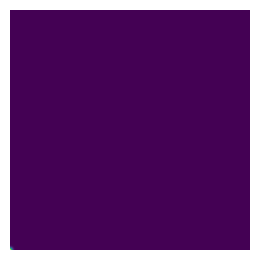

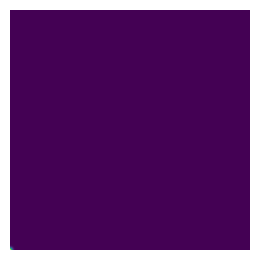

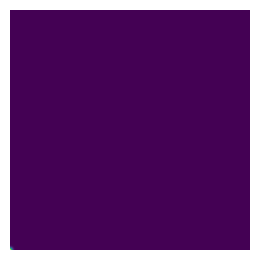

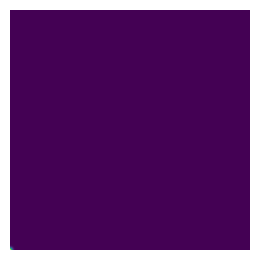

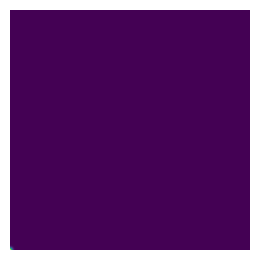

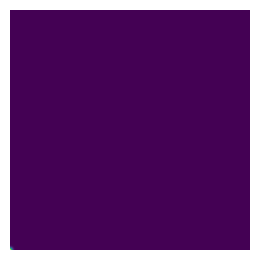

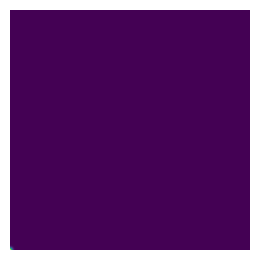

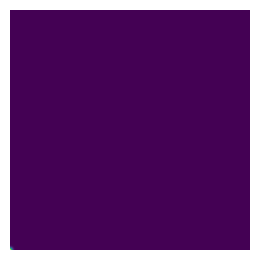

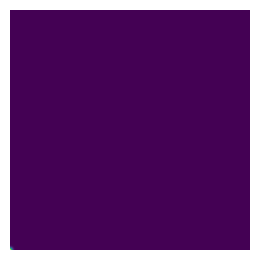

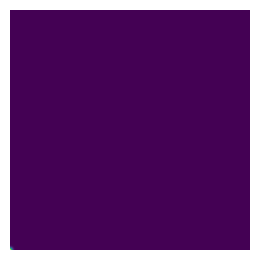

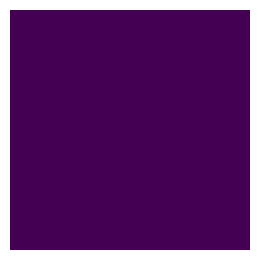

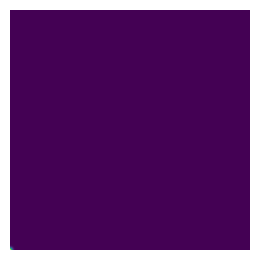

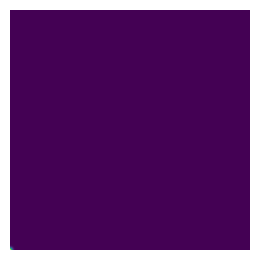

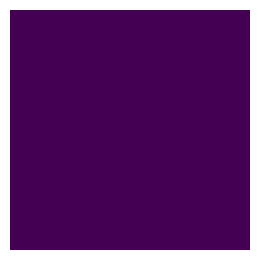

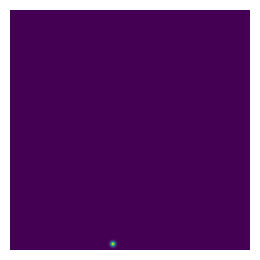

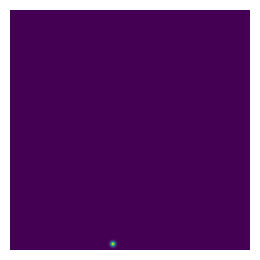

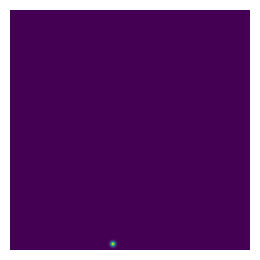

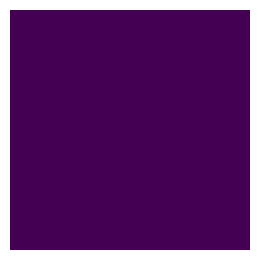

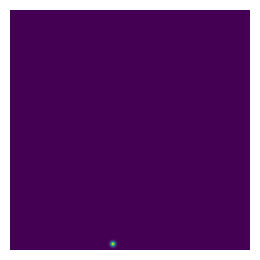

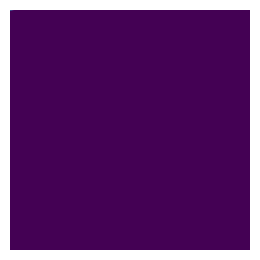

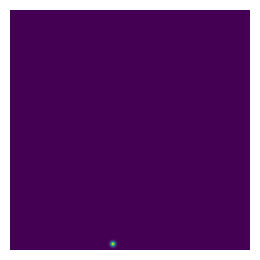

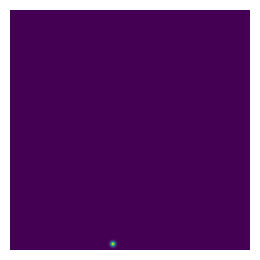

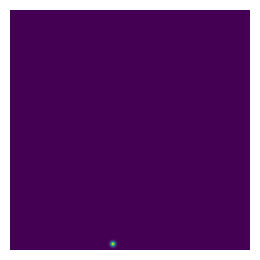

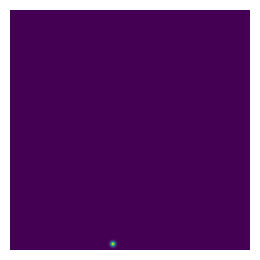

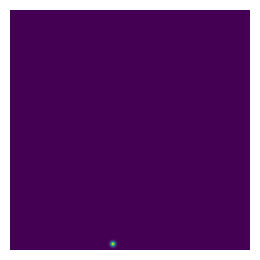

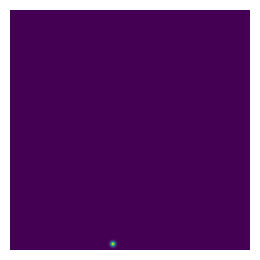

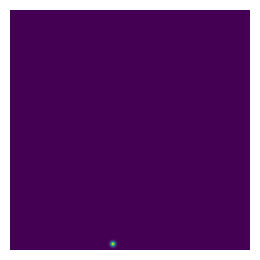

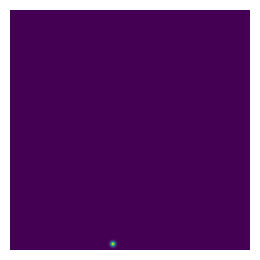

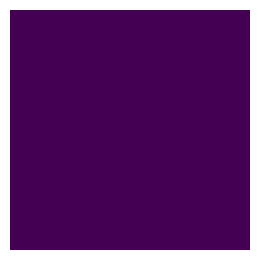

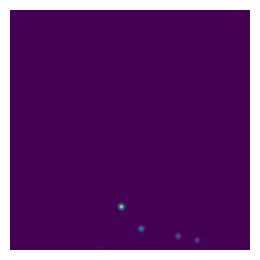

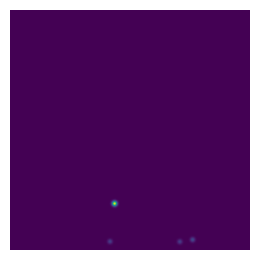

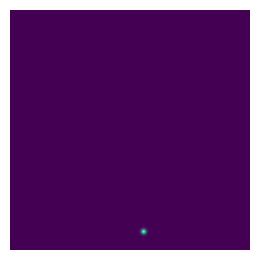

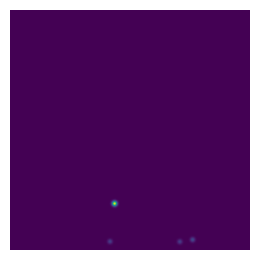

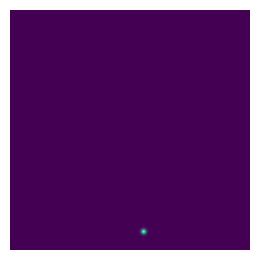

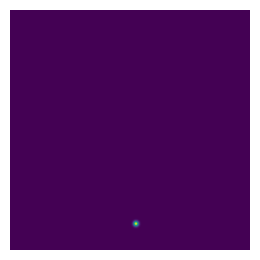

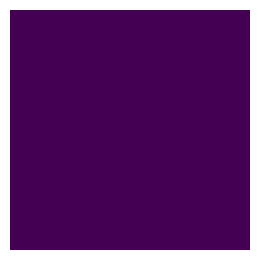

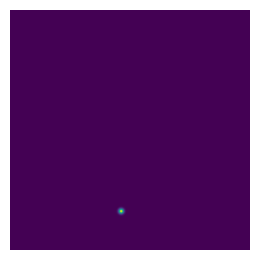

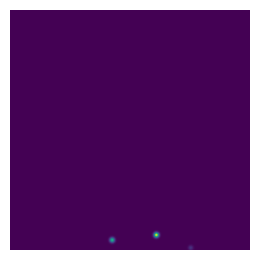

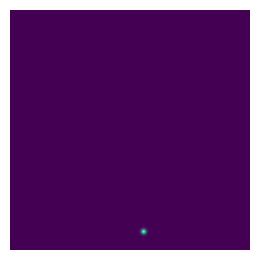

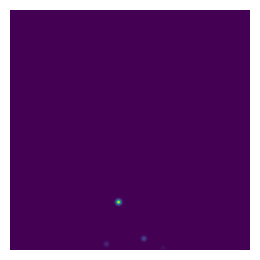

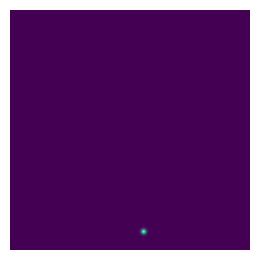

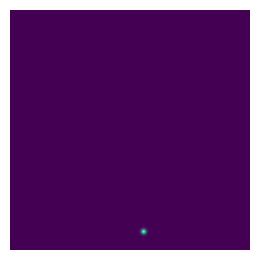

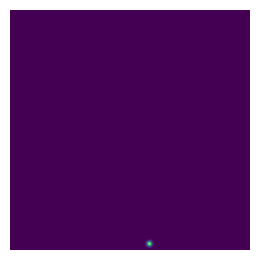

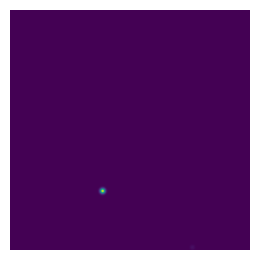

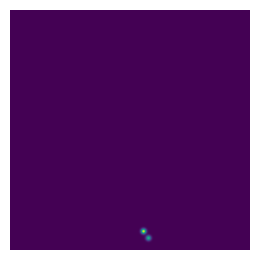

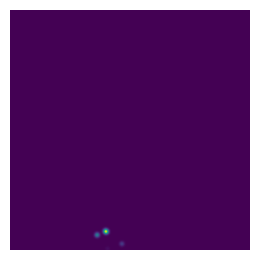

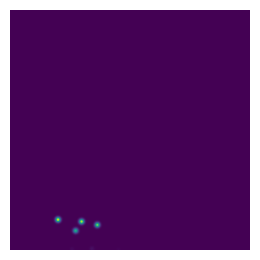

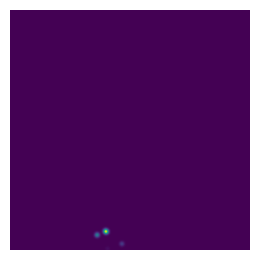

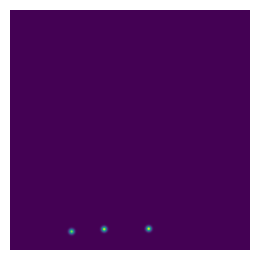

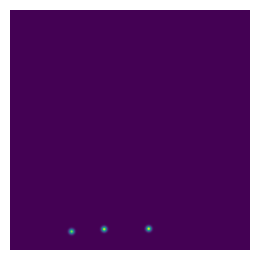

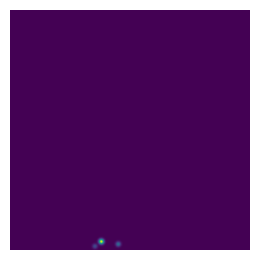

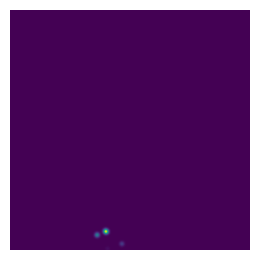

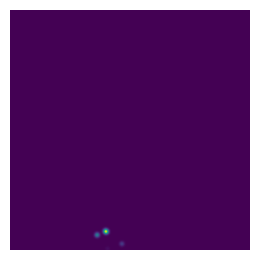

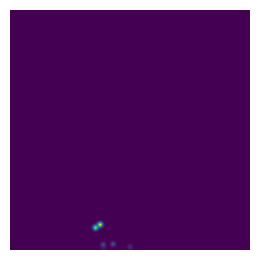

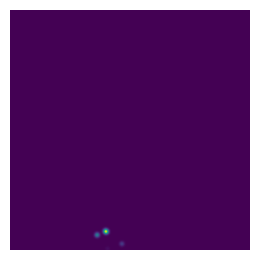

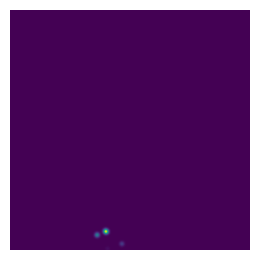

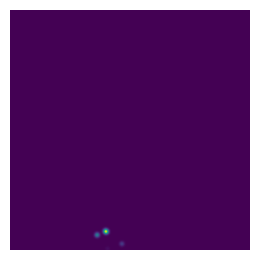

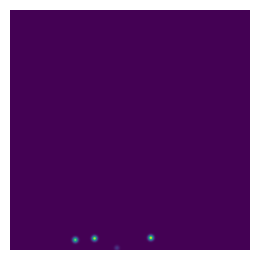

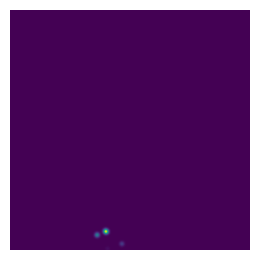

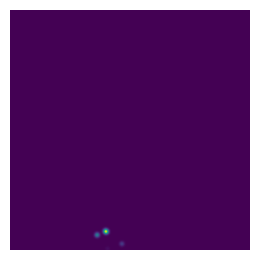

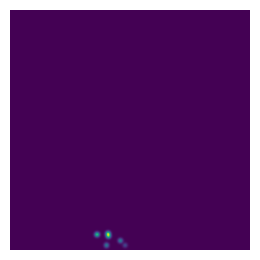

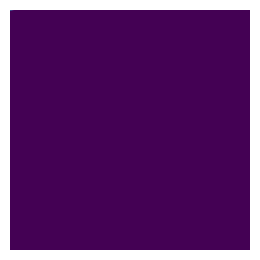

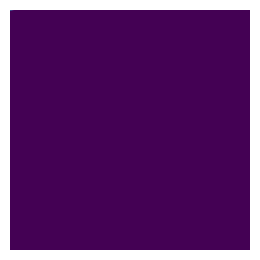

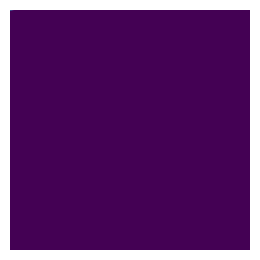

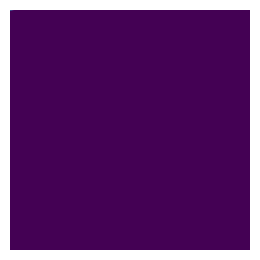

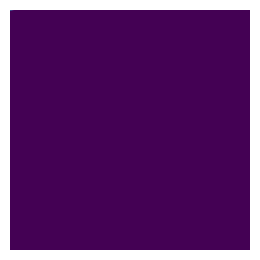

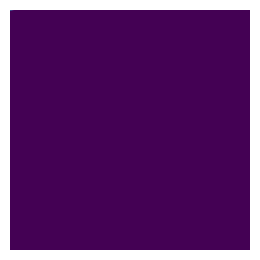

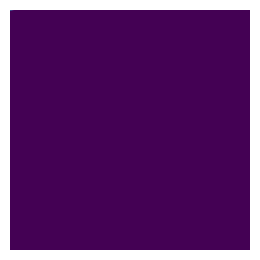

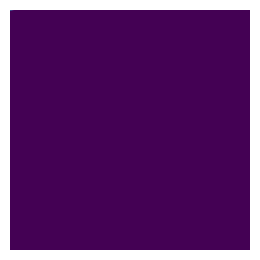

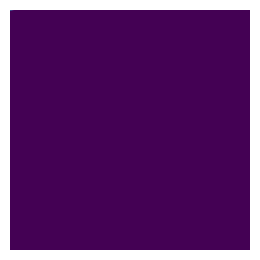

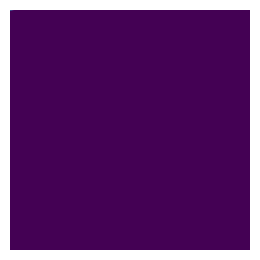

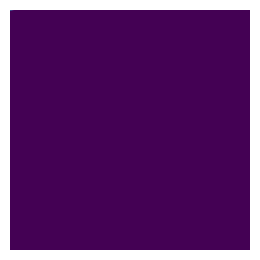

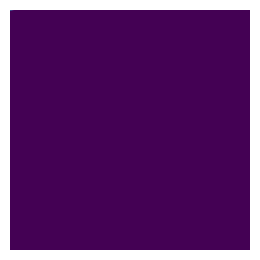

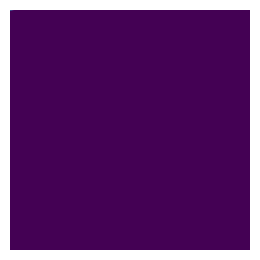

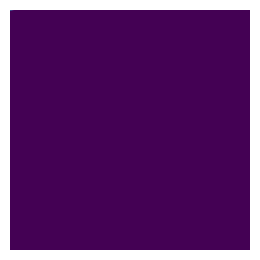

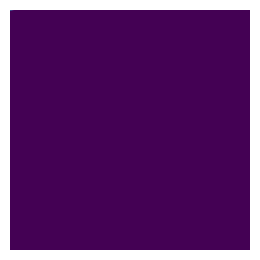

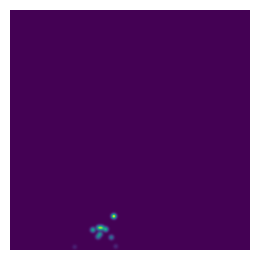

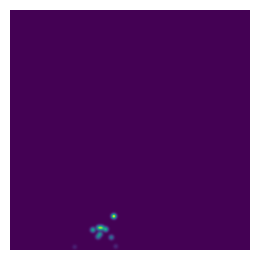

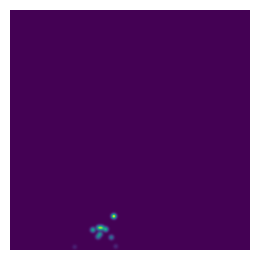

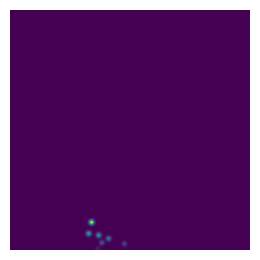

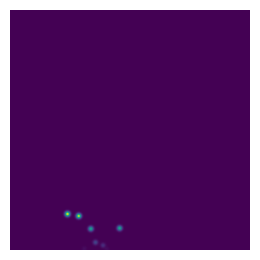

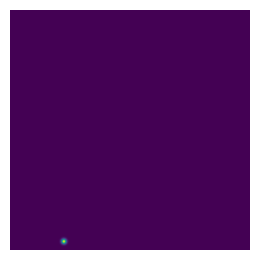

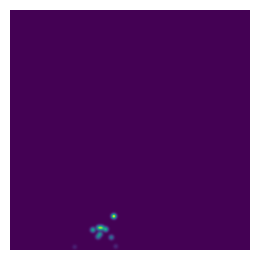

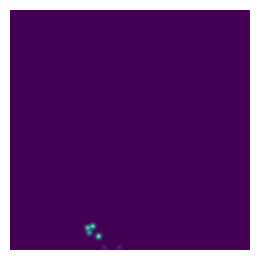

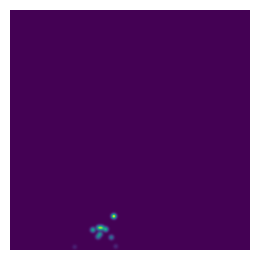

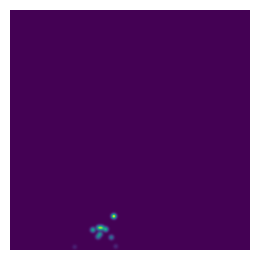

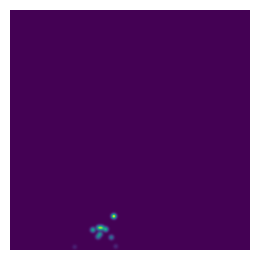

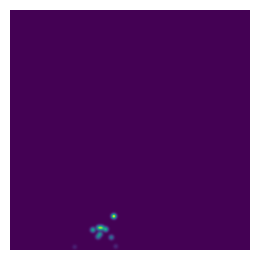

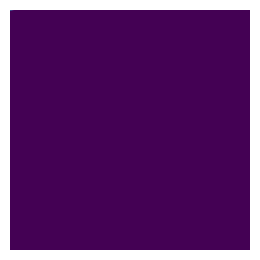

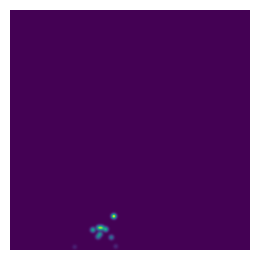

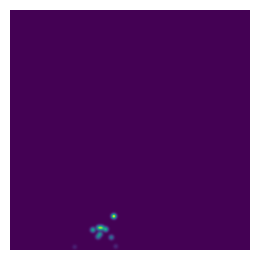

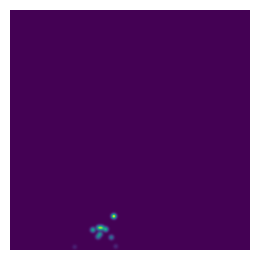

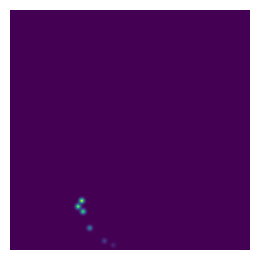

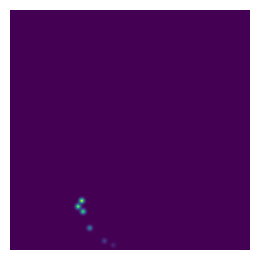

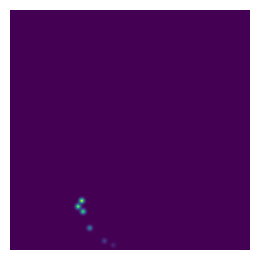

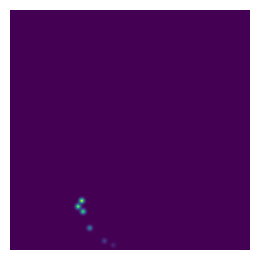

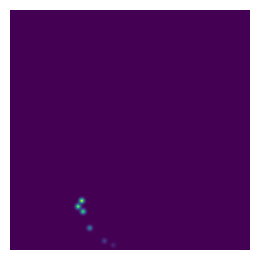

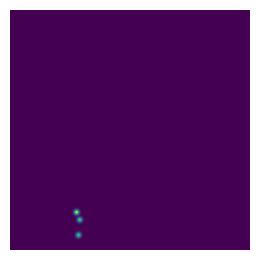

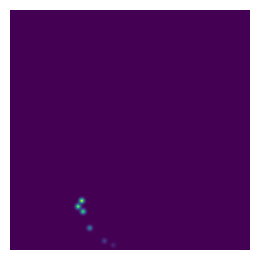

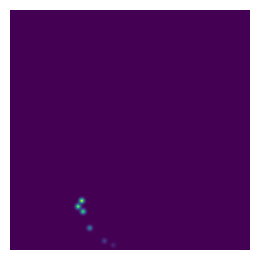

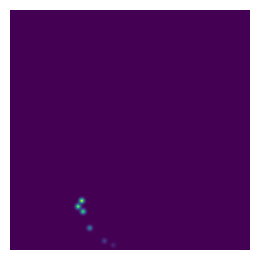

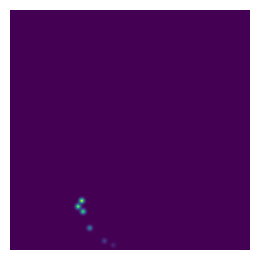

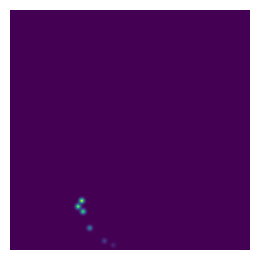

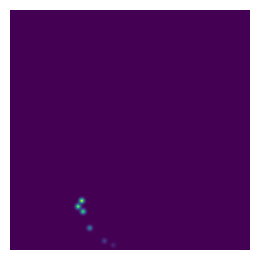

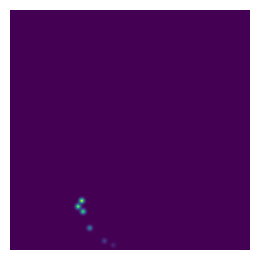

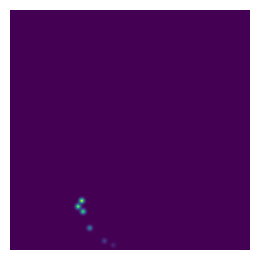

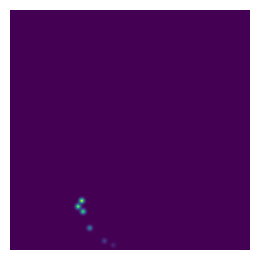

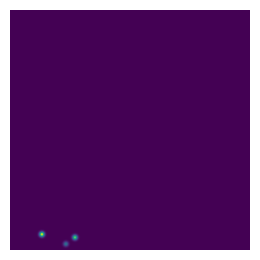

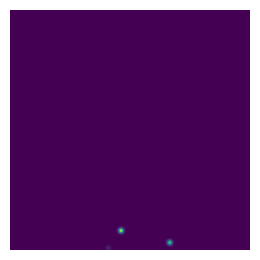

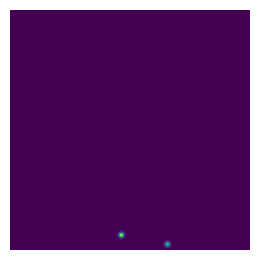

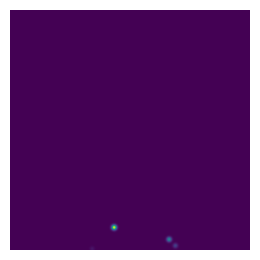

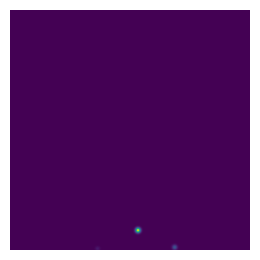

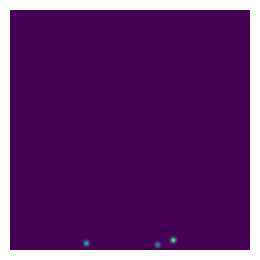

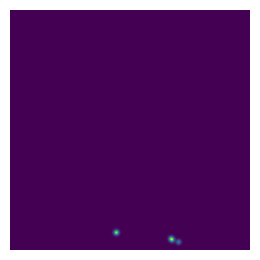

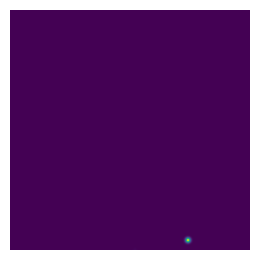

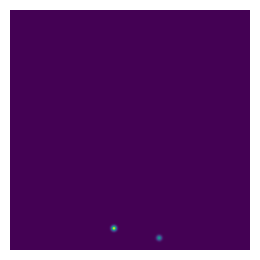

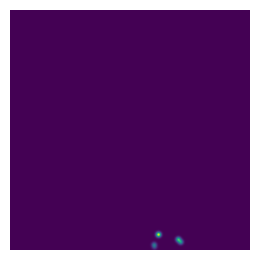

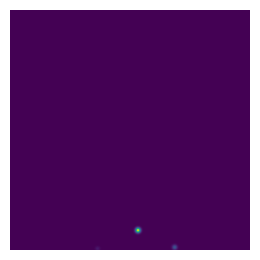

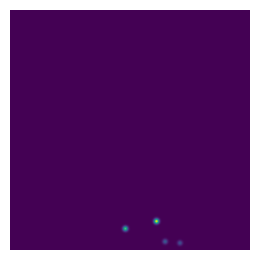

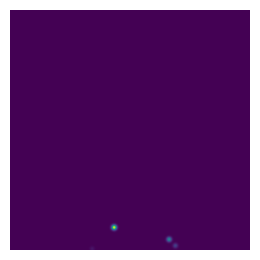

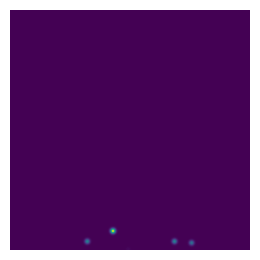

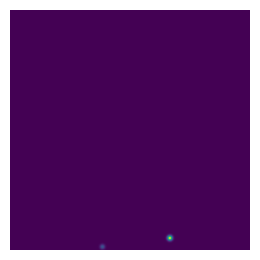

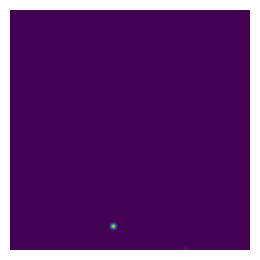

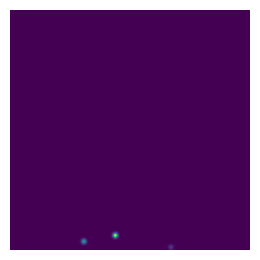

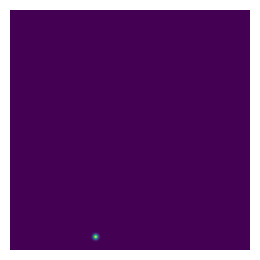

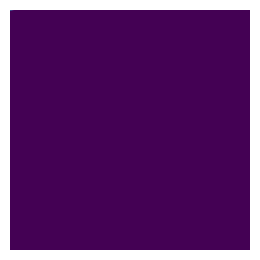

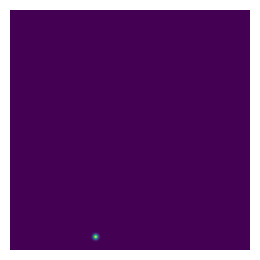

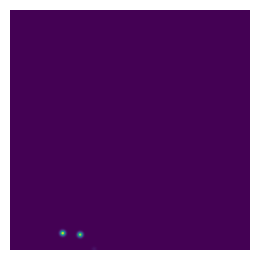

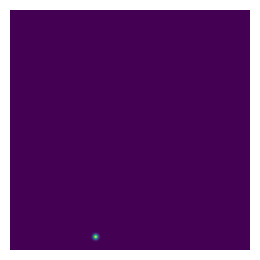

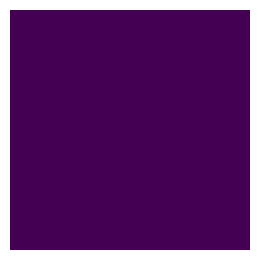

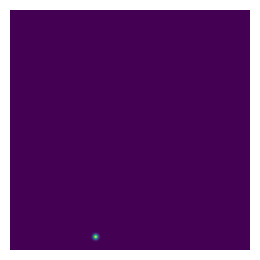

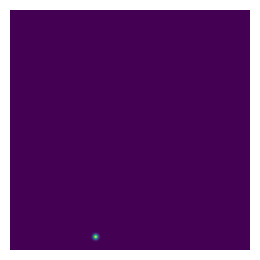

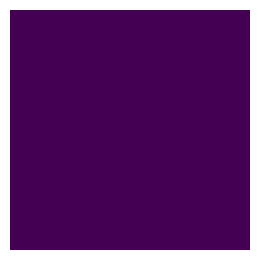

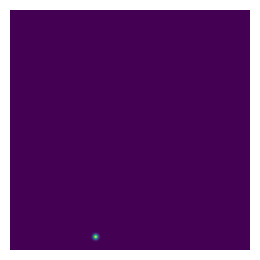

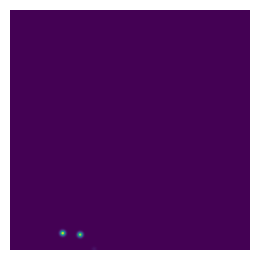

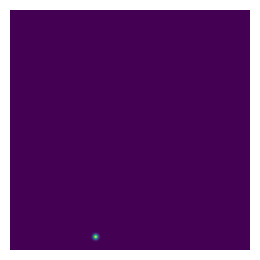

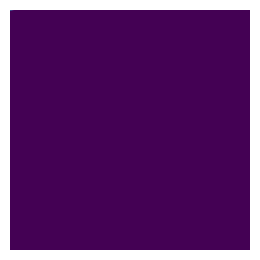

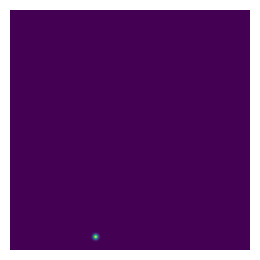

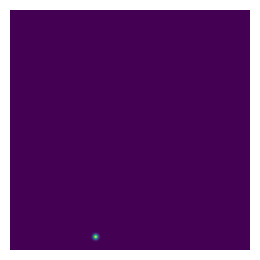

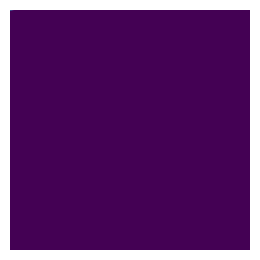

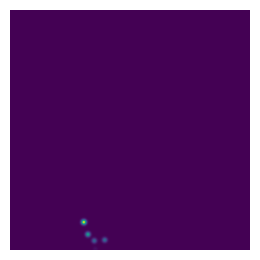

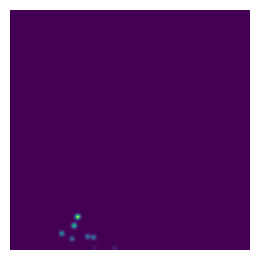

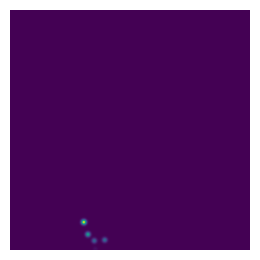

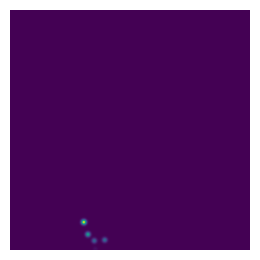

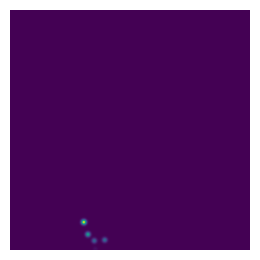

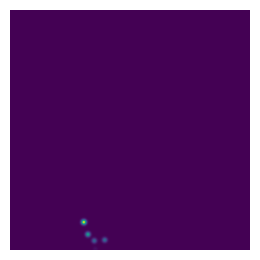

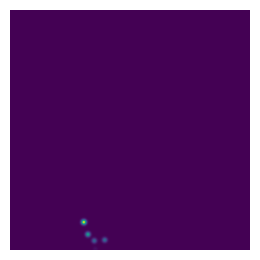

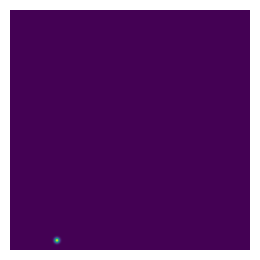

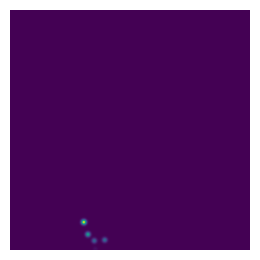

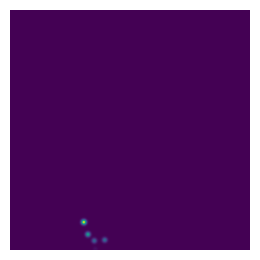

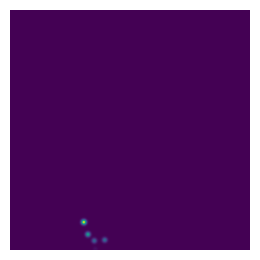

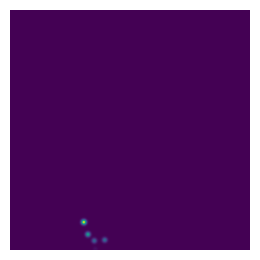

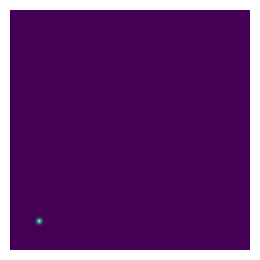

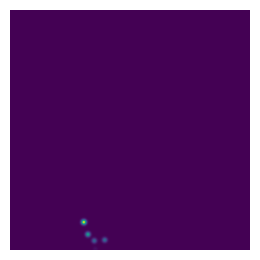

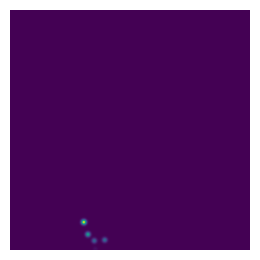

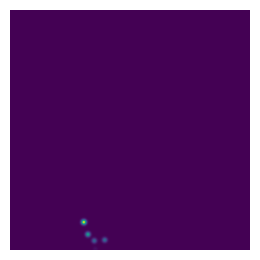

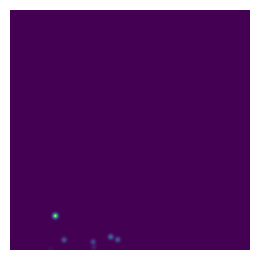

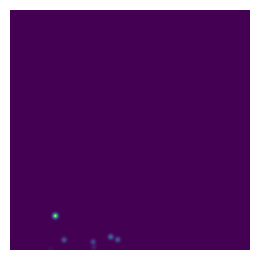

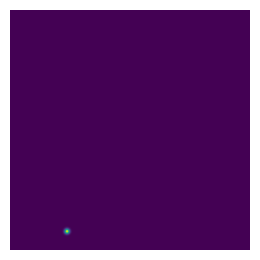

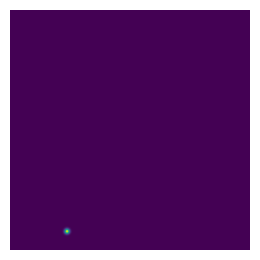

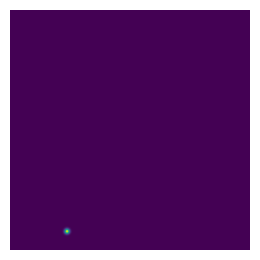

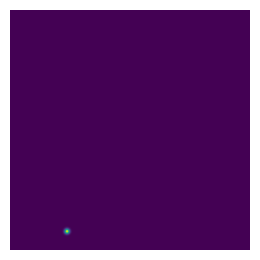

In [14]:
# Loop through each state
for state in tqdm(states, desc="Processing states"):
    print('Processing:', state)

    try:
        # Load data from pickle files into a dictionary
        data = {}

        for file in glob.glob(os.path.join(DATA_DIR, state, '*.pkl')):
            with open(file, 'rb') as f:
                
                # Extract the last 20 characters of the file name
                extracted_words = file[-20:]

                # Search for numbers in the extracted string
                match = re.search(r'(\d+)', extracted_words)
                if match:
                    extracted_number = match.group(1)
                    # Load the pickle file data into the dictionary
                    data[extracted_number] = pd.read_pickle(f)
                else:
                    print("No number found in the string.")

                 # Process each county (FIPS) in the data
        for fips, dictionary in data.items():
            # Dictionary where the key is the county code (FIPS) and the value is another dictionary
            # print('Processing:', fips)

            for key, value in dictionary.items():

                # If the value is not empty, process it
                if len(value) > 0:
                    distance_matrix = np.zeros((NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES))

                    # get the selected fips realated to the specific variable
                    selected_fips = value['FIPS'].tolist()
     
                    # filter the dataframe svi_df to only include the selected fips
                    svi_df_selected_fips = us_svi[us_svi['FIPS'].isin(selected_fips)]
                    svi_df_selected_fips = svi_df_selected_fips[VARIABLES]

                    # create a matrix
                    data_matrix = svi_df_selected_fips.to_numpy()

                    # compute the distance matrix
                    for i in range(NUMBER_OF_VARIABLES):
                        for j in range(NUMBER_OF_VARIABLES):
                            distance_matrix[i, j] = dcor.distance_correlation(data_matrix[:, i], data_matrix[:, j]) #Distance Correlations 

                    distance_matrix = distance_matrix.T + np.eye(NUMBER_OF_VARIABLES)
                    distance_matrix = 1 - distance_matrix

                    # Create persistence diagram using Rips class
                    rips = Rips(maxdim=1, coeff=2)
                    dgms = ripser.ripser(distance_matrix, distance_matrix=True)['dgms']

                    # Separate the diagrams for H0 and H1
                    diagrams_h0 = dgms[0]
                    diagrams_h1 = dgms[1]

                    # If H0 diagram is not empty, process it
                    if len(diagrams_h0) > 1: 
                        # Remove last data point in H0 diagram (it is infinity)
                        diagrams_h0_without_inf = diagrams_h0[0:-1]

                        pimgr_0 = PersistenceImager(pixel_size = PERSISTENCE_IMAGE_PARAMS['pixel_size'])
                        pimgr_0.fit(diagrams_h0_without_inf)

                        pimgr_0.pixel_size = PERSISTENCE_IMAGE_PARAMS['pixel_size']
                        pimgr_0.birth_range = PERSISTENCE_IMAGE_PARAMS['birth_range']
                        pimgr_0.pers_range = PERSISTENCE_IMAGE_PARAMS['pers_range']
                        pimgr_0.kernel_params = PERSISTENCE_IMAGE_PARAMS['kernel_params']

                        image_h0 = pimgr_0.transform(diagrams_h0_without_inf)

                    # If H1 diagram is not empty, process it
                    if len(diagrams_h1) > 0:
                        pimgr_1 = PersistenceImager(pixel_size = PERSISTENCE_IMAGE_PARAMS['pixel_size'])
                        pimgr_1.fit(diagrams_h1)

                        pimgr_1.pixel_size = PERSISTENCE_IMAGE_PARAMS['pixel_size']
                        pimgr_1.birth_range = PERSISTENCE_IMAGE_PARAMS['birth_range']
                        pimgr_1.pers_range = PERSISTENCE_IMAGE_PARAMS['pers_range']
                        pimgr_1.kernel_params = PERSISTENCE_IMAGE_PARAMS['kernel_params']

                        image_h1 = pimgr_1.transform(diagrams_h1)
                    
                    # Save the persistence image
                    save_path = os.path.join(RESULTS_DIR, key, fips)

                    if len(diagrams_h0) > 1 and len(diagrams_h1) > 0:
                        peristence_image = np.rot90(image_h0 + image_h1, k=1) 
                        plt.figure(figsize=(2.4, 2.4))
                        plt.imshow(peristence_image, cmap='viridis')  # Assuming 'viridis' colormap, change as needed
                        plt.axis('off')  # Turn off axis
                        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust subplot parameters to remove borders
                        plt.savefig(save_path + '.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save the image
                        # np.save(save_path, peristence_image)
                    
                    elif len(diagrams_h0) > 1 and len(diagrams_h1) == 0:
                        peristence_image = np.rot90(image_h0, k=1) 
                        # np.save(save_path, peristence_image)
                        plt.figure(figsize=(2.4, 2.4))
                        plt.imshow(peristence_image, cmap='viridis')  # Assuming 'viridis' colormap, change as needed
                        plt.axis('off')  # Turn off axis
                        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust subplot parameters to remove borders
                        plt.savefig(save_path + '.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save the image
                    
                    elif len(diagrams_h0) < 1 and len(diagrams_h1) > 0:
                        peristence_image = np.rot90(image_h1, k=1) 
                        # np.save(save_path, peristence_image)
                        plt.figure(figsize=(2.4, 2.4))
                        plt.imshow(peristence_image, cmap='viridis')  # Assuming 'viridis' colormap, change as needed
                        plt.axis('off')  # Turn off axis
                        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust subplot parameters to remove borders
                        plt.savefig(save_path + '.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save the image
                    
                    else:
                        peristence_image = np.zeros(PERSISTENCE_IMAGE_SHAPE)
                        # np.save(save_path, peristence_image)

                else:
                    # If there is no data to compute persistence image, save an empty image
                    peristence_image = np.zeros(PERSISTENCE_IMAGE_SHAPE)
                    # np.save(os.path.join(RESULTS_DIR, key, fips), peristence_image)

                    # break
                # break
                

            # break
        
        # break

    except Exception as e:
        print(f"Error processing {state}: {e}")
        traceback.print_exc()
        continue  # Continue to the next iteration if an error occurs

print('All states processed.')